# **Comprendiendo la Ciencia en Tiempos de Crisis: Un Estudio del CORD-19 con Técnicas de NLP**

**Alumno:** Silvia Maria Gamarra Morel



Se utilizará el corpus COVID-19 Open Research Dataset Challenge (CORD-19), una colección en constante crecimiento de literatura científica relacionada con el virus SARS-CoV-2 y otros coronavirus. Primeramente se entrenará un modelo fine-tunning BioBERT para clasificación binaria, para luego utilizar RAG para clasificar los textos y hacer consultas sobre las mismas.

**Link Dataset:** https://www.kaggle.com/datasets/allen-institute-for-ai/CORD-19-research-challenge

# Desarrollo de la funciones e instalación de las librerias

**1. Instalar Librerias**

Transformers y Datasets de Hugging Face
Scikit-Learn para métricas (accuracy, f1) y divisiones (train/test split)

In [ ]:
!pip install transformers datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00


**2. Cargar las librerias de transformers para poder cargar los modelos y tokenizar los mismos**

En el desarrollo inicial se utilizá AutoModelForSequenceClassification: ya tiene la "cabeza" para predecir clases directamente y servira para el entrenamiento supervisado que se hará.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

**3. Cargar los modelos**

Como el dataset CORD-19 tiene textos de biomedicina + ciencia general (CORD-19 + papers de vacunas, informática médica, etc.) se utilizará BioBERT y SciBERT para hace ensemble (combinar las salidas (los logits) de ambos modelos) y hacer promedio de logits + softmax, con esto se utiliza la clase que tiene mayor valor para hacer las predicciones.

**BioBERT**

**Biomédico puro (enfermedades, virus, síntomas)**   
Para el entranamiento se utilizará la versión BioBERT v1.1, que según referencias es el más probado y estable. Hay un versión nueva, la  v1.2, lanzada en octubre en el 2024, más flexible y con capacidad de generar texto biomedico, pero como en este proyecto solo se quiere identificar temas, tipos de estudios, hallazgos médicos e investigaciones hechas referentes al COVID-19, con la versión 1.1 bastará para el fine-tunning y el entrenamiento.

In [ ]:
def cargar_modelo_biobert():
  """
  Carga el tokenizador y el modelo preentrenado BioBERT v1.1

  Returns:
    - Tupla que contiene el tokenizador y el modelo BioBERT.
    - El primer elemento es el tokenizador (AutoTokenizer) y el segundo es el modelo (AutoModelForSequenceClassification).
  """
  # Cargar modelo
  biobert_tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
  # Cargar tokenizador del modelo
  biobert_model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

  return biobert_tokenizer, biobert_model


**SciBERT**

**Artículos científicos de muchas disciplinas**   
Es más amplio que BioBERT, ya que fue entredos con corpus de ciencia en general(física, biomedicina, biologia, química, computación).  
Se utilizará la versión scibert_scivocab_cased, ya que se leeran papers relacionados al COVID-19 y necesario que el modelo pueda diferenciar mayúsculas de minúsculas.

In [ ]:
def cargar_modelo_scibert():
  """
  Carga el tokenizador y el modelo preentrenado SciBERT.
  Se carga desde la versión la versión 'cased'.

  Returns:
    - Tupla que contiene el tokenizador y el modelo SciBERT.
    - El primer elemento es el tokenizador (AutoTokenizer) y el segundo es el modelo (AutoModelForSequenceClassification).
  """
  # Cargar modelo
  scibert_tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_cased")
  # Cargar tokenizador del modelo
  scibert_model = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_cased")

  return scibert_tokenizer, scibert_model

Para ambos modelos preentrenados, salió la advertencia que tiene los embeddings, pero no sabe aún cómo hacer una clasificación directa hasta que se haga el entrenamiento con el corpus. Previamente hay que hacer fine-tuning antes de usar el modelo para predicciones.

**4. Cargar el dataset alojado en Google Drive y preprocesarlo**

El archivo que contiene el corpus CORD-19 está cargado en Google Drive.  
Para trabajar con el mismo se montar la carpeta que lo contiene, descomprimir, carga la metadata y preprocesar.  
Se hará una validación visual de los primeros registros que contiene el corpus.

Cargar y descomprimir

In [ ]:
# Montar la unidad
# Para este trabajo se decidio trabajar con Google Drive, pero si quiere trabajar con otra unidad de almacenamiento, es a libre decisión.
def montar_drive():
    """
    Montar la unidad de Google Drive en el entorno de Colab.
    No hay return.
    """
    from google.colab import drive
    drive.mount('/content/drive')


# Extraer .zip
def extraer_zip(zip_path, extract_to):
    """
    La función pedirá como parametro la ruta dónde esta almacenado el archivo .zip y la ruta donde se extraerá.
    Se utiliza la librería zipfile para extraer el archivo.

    Parámetros:
     - zip_path: ruta del archivo .zip
     - extract_to: ruta donde se extraerá el archivo

    No hay return.
    """
    import zipfile
    import time
    import os

    # Se captura el momento de inicio de la descompresión
    start_time = time.time()

    # Crear carpeta de destino si no existe
    os.makedirs(extract_to, exist_ok=True)

    # Se va abrir el archivo en modo lectura
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Archivo '{zip_path}' descomprimido en '{extract_to}'.")

    elapsed_time = time.time() - start_time
    print(f"Descompresión terminada en {elapsed_time/60:.2f} minutos")

# Ver tamaño de la carpeta descomprimida
def get_size_carpeta_descomprimida(folder_path):
    """
    Muestra el tamaño de la carpeta especificada

    Parámetros:
    - folder_path: ruta de la carpeta a evaluar

    No hay return.
    """
    import os
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # Evitar errores si algún archivo se borra durante el conteo
            if os.path.exists(fp):
                total_size += os.path.getsize(fp)
    return total_size



Carga del metadata

In [ ]:
import pandas as pd
import json
import os
from datasets import Dataset

def load_metadata(metadata_path):
    """
       Carga el archivo metadata.csv como DataFrame.

       Parámetros:
       - metadata_path: Ruta al archivo metadata.csv.

       Returns:
       DataFrame con los metadatos.
    """
    return pd.read_csv(metadata_path)

def load_article_text(json_path):
    """
       Carga un archivo .json de un artículo y extrae el título, resumen y cuerpo.
       Además, extrae los artículos de referencia y artículos citados.

       Parámetro:
       - json_path: Ruta al archivo .json.

       Returns:
       - Tupla con el  título, resumen, cuerpo del artículo, artículos de referencia y artículos citados.
    """
    try:
        with open(json_path, 'r') as f:
            paper = json.load(f)

        # Título
        title = paper.get('metadata', {}).get('title', '')

        # Abstract (puede venir en forma de lista)
        abstract_parts = paper.get('abstract', [])
        abstract = ' '.join([part.get('text', '') for part in abstract_parts])

        # Body text (texto del artículo completo)
        body_parts = paper.get('body_text', [])
        body_text = ' '.join([part.get('text', '') for part in body_parts])

        # Bibliographic entries (referencias) - Articulos bibliografías
        bib_entries_parts = paper.get('bib_entries', {})
        bib_entries_list = []
        for entry_id, entry_data in bib_entries_parts.items():
            entry_title = entry_data.get('title', 'Título no disponible')
            authors_data = entry_data.get('authors', [])
            authors = ', '.join([f"{a.get('first', '')} {a.get('last', '')}".strip() for a in authors_data]) or 'Autor(es) no disponible'
            year = entry_data.get('year', 'Año no disponible')
            bib_entries_list.append(f"Título: {entry_title}, Autores: {authors}, Año: {year}")

        bib_entries = ' || '.join(bib_entries_list) or 'No hay referencias bibliográficas disponibles.'

        # Reference entries (artículos citados en cuerpo) - Articulos de referencia
        ref_entries_parts = paper.get('ref_entries', {})
        ref_entries_list = []
        for entry_id, entry_data in ref_entries_parts.items():
            entry_title = entry_data.get('text', 'Título no disponible')
            # Nota: ref_entries generalmente no tiene autores ni año, pero podrías agregarlo si existiera.
            ref_entries_list.append(f"Título: {entry_title}")

        ref_entries = ' || '.join(ref_entries_list) or 'No hay artículos citados disponibles.'

        return title, abstract, body_text, bib_entries, ref_entries

    except Exception as e:
        print(f"Error cargando {json_path}: {e}")
        return 'Título no disponible', 'Resumen no disponible', 'Cuerpo no disponible', 'No hay referencias bibliográficas disponibles.', 'No hay artículos citados disponibles.'



Built Dataset v1 - Solo se lee los archivos de la carpta pdf_json

In [ ]:
def build_dataset_v1(metadata_df, pdf_json_folder, num_samples=100):
    """
       Construye un dataset de HF a partir del metadata y artículos .json.
       En la función el número de muestras a cargar es 100 por defecto.

       Parámetros:
       - metadata_df: DataFrame con los metadatos.
       - pdf_json_folder: Ruta a la carpeta con archivos JSON PDF.
       - num_samples: Número máximo de muestras a cargar (por defecto 100).

       Returns:
       - dataset Huging Face.
    """
    samples = []

    for idx, row in metadata_df.iterrows():
        sha = row['sha']

        """
          Del los archivos .json se tomará:
           * El título
           * El resumen
           * El cuerpo del artículo
           * Los artículos de referencia
           * Los artículos citados
        """
        # Algunos registros tienen múltiples SHA separados por ;
        if isinstance(sha, str):
            first_sha = sha.split(';')[0]
            json_path = os.path.join(pdf_json_folder, f"{first_sha}.json")

            if os.path.exists(json_path):
                title, abstract, body_text, bib_entries, ref_entries  = load_article_text(json_path)

                if title or abstract or body_text or bib_entries or ref_entries:
                    samples.append({
                        'title': title,
                        'abstract': abstract,
                        'body_text': body_text,
                        'bib_entries': bib_entries,
                        'ref_entries': ref_entries
                    })

        if len(samples) >= num_samples:
            break

    # Crea Hugging Face Dataset
    dataset = Dataset.from_list(samples)
    return dataset


Built Dataset v2 - Solo se lee los archivos de la carpta pmc_json

In [ ]:
def build_dataset_v2(metadata_df, pmc_json_folder, pdf_json_folder, num_samples=100):
    """
    Construye un dataset Hugging Face usando archivos .json del corpus CORD-19.
    Da prioridad a los archivos en 'pmc_json', y si no existen, usa los de 'pdf_json'.

    Parámetros:
    - metadata_df: DataFrame con los metadatos.
    - pmc_json_folder: Ruta a la carpeta con archivos JSON PMC.
    - pdf_json_folder: Ruta a la carpeta con archivos JSON PDF.
    - num_samples: Número máximo de muestras a cargar (por defecto 100).

    Return:
    - Dataset de Hugging Face.
    """
    samples = []

    for idx, row in metadata_df.iterrows():
        sha = row['sha']

        if isinstance(sha, str):
            first_sha = sha.split(';')[0]

            # Intentar con pmc_json
            pmc_path = os.path.join(pmc_json_folder, f"{first_sha}.json")
            pdf_path = os.path.join(pdf_json_folder, f"{first_sha}.json")

            if os.path.exists(pmc_path):
                json_path = pmc_path
            elif os.path.exists(pdf_path):
                json_path = pdf_path
            else:
                continue  # Ninguna versión disponible

            title, abstract, body_text, bib_entries, ref_entries = load_article_text(json_path)

            if title or abstract or body_text or bib_entries or ref_entries:
                samples.append({
                    'title': title,
                    'abstract': abstract,
                    'body_text': body_text,
                    'bib_entries': bib_entries,
                    'ref_entries': ref_entries
                })

            # Mostrar progreso cada 1000 muestras cargadas
            if len(samples) % 1000 == 0:
                print(f"{len(samples)} muestras cargadas...")

        if len(samples) >= num_samples:
            break

    print(f"Total de muestras cargadas: {len(samples)}")
    dataset = Dataset.from_list(samples)
    return dataset


Limpieza del dataset

In [ ]:
# Se limpia la columna que contiene el texto y se guarda el texto limpio en una nueva columna
def preparar_data(dataset, combine_fields=True, fields_to_combine=('title', 'abstract'), new_field_name='text'):
    """
    Prepara el dataset para tareas de NLP.
    Argumentos que requiere la función:
        dataset: objeto Dataset de Hugging Face.
        combine_fields: bool, si True combina varias columnas en una nueva.
        fields_to_combine: tuple, nombres de columnas a combinar.
        new_field_name: str, nombre de la nueva columna combinada.

    Returns: dataset procesado listo para modelado.
    """

    if combine_fields:
        def combine_examples(example):
            combined = ' '.join(
                (example.get(field) or '') for field in fields_to_combine
            ).strip()
            example[new_field_name] = combined
            return example

        dataset = dataset.map(combine_examples)

    return dataset


**5. Agregar la columna label**

Para crear la columna label en el dataset CORD-19, se va a usar una heurística simple, solo se va a buscar si los artículos hacen referencia directa al COVID-19 o enfermedades relacionadas. Dado que CORD-19 contiene miles de artículos científicos recopilados durante la pandemia, muchos están etiquetados indirectamente por su contenido textual.

Se creara una etiqueta binaria:

* 1 si el texto habla de COVID-19 o temas relacionados

* 0 si no lo hace


In [ ]:
covid_keywords = [
    'covid', 'coronavirus', 'covid-19', 'covid19',
    'sars-cov-2', 'pandemic', 'novel coronavirus', '2019-ncov'
]

def label_add(example):
    # Combina los campos relevantes en minúsculas
    full_text = f"{example['title']} {example['abstract']} {example['body_text']}".lower()

    # Devuelve la nueva columna 'label'
    return {
        'label': int(any(keyword in full_text for keyword in covid_keywords))
    }



**6. Dividir el dataset en los conjuntos entranamiento(train), validación(val) y test**

Se tomará el detaset generado con la versión 2 de la función para dividir el conjunto de datos

In [ ]:
def split_dataset(dataset, train_size=0.8, val_size=0.1, test_size=0.1, seed=42):
    """
    Divide un dataset en subconjuntos de entrenamiento, validación y prueba.

    Parámetros:
    - dataset: objeto datasets.Dataset o DatasetDict (sin splits).
    - train_size: proporción del conjunto de entrenamiento (por defecto 0.8).
    - val_size: proporción del conjunto de validación (por defecto 0.1).
    - test_size: proporción del conjunto de prueba (por defecto 0.1).
    - seed: semilla para aleatorizar la partición.

    Return:
    - Un DatasetDict con keys 'train', 'validation' y 'test'.
    """
    from datasets import DatasetDict

    assert abs((train_size + val_size + test_size) - 1.0) < 1e-6, "Las proporciones deben sumar 1."

    # Dividir en train y temp
    train_test_split = dataset.train_test_split(test_size=(val_size + test_size), seed=seed)

    # Dividir el "temp" en validación y prueba
    temp = train_test_split['test'].train_test_split(test_size=test_size / (test_size + val_size), seed=seed)

    # Crear el DatasetDict final
    final_splits = DatasetDict({
        'train': train_test_split['train'],
        'validation': temp['train'],
        'test': temp['test']
    })

    return final_splits


**7. Tokenizar los dataset divididos con el tokenizador que le corresponde a cada modelo**

Según referencias no se recomienda usar directamente las columnas bib_entries y ref_entries para entrenar el modelo como BioBERT, por lo cual para el entrenamiento solo se utilizará las columnas que contienen el título, abstract y el body_text

In [ ]:
def tokenize_multicolumn_biobert(dataset_splits, max_length=512):
    """
    Tokeniza los datasets de entrenamiento, validación y prueba usando las columnas
    'title', 'abstract' y 'body_text' concatenadas como entrada para BioBERT.

    Parámetros:
    - dataset_splits: DatasetDict con los splits 'train', 'validation' y 'test'.
    - max_length: número máximo de tokens (BioBERT: 512 por defecto).

    Return:
    - DatasetDict con los textos tokenizados.
    """
    tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

    def tokenize_function(dataset):
        # Concatenar las columnas a ser utilizadas para el entrenamiento
        combined_text = [
            f"{title} {abstract} {body_text}"
            for title, abstract, body_text in zip(dataset['title'], dataset['abstract'], dataset['body_text'])
        ]  # Use zip to iterate over corresponding elements
        return tokenizer(
            combined_text,
            truncation=True,
            padding='max_length',
            max_length=max_length
        )

    # Tokenizar todos los splits
    tokenized_datasets = dataset_splits.map(tokenize_function, batched=True)

    return tokenized_datasets


**8. Fine Tunning para entrenar el modelo BioBERT**

Fine-tuning para Entrenamiento 1

Se utilizará el conjunto de datos train y test para el entrenamiento del modelo, el conjunto de datos test se dejará para evaluar si arroja las mismas métricas

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

def train_biobert_classifier(tokenized_dataset, num_labels=2, output_dir="./biobert-model", model_checkpoint="dmis-lab/biobert-base-cased-v1.1"):
    """
    Entrena un modelo BioBERT para una tarea de clasificación de texto.

    Parámetros:
    - tokenized_dataset: DatasetDict ya tokenizado.
    - num_labels: número de clases (por ejemplo, 2 para clasificación binaria).
    - output_dir: ruta donde se guardará el modelo.
    - model_checkpoint: checkpoint del modelo base.

    Return:
    - trainer: objeto Trainer con el modelo entrenado.
    """
    # Carga el modelo BioBERT adaptado a clasificación
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

    # Argumentos de entrenamiento
    training_args = TrainingArguments(
        output_dir="./results_biobert",         # Carpeta de salida
        eval_strategy="steps",                  # Evaluación cada cierto número de pasos
        eval_steps=500,                         # Frecuencia de evaluación
        logging_steps=100,                      # Frecuencia de logs
        save_steps=1000,                        # Guardar checkpoints
        per_device_train_batch_size=8,          # Tamaño de batch en entrenamiento
        per_device_eval_batch_size=16,          # Tamaño de batch en evaluación
        num_train_epochs=3,                     # Épocas
        learning_rate=2e-5,                     # Learning rate recomendado para BERT
        weight_decay=0.01,                      # Regularización
        warmup_steps=500,                       # Calentamiento del scheduler
        logging_dir="./logs",                   # Directorio para logs
        save_total_limit=2,                     # Cuántos checkpoints conservar
        load_best_model_at_end=True,            # Usa el mejor modelo según la métrica
        metric_for_best_model="f1",             # Métrica para determinar el mejor modelo
        seed=42                                 # Reproducibilidad
    )


    # Carga las métricas de evaluación desde evaluate
    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")
    precision = evaluate.load("precision")
    recall = evaluate.load("recall")

    def compute_metrics(eval_pred):
        """
        Calcula métricas de evaluación: accuracy, F1 (ponderado), precisión y recall.

        Parámetro:
        - eval_pred: tupla (logits, etiquetas verdaderas)

        Retorna:
        - Diccionario con métricas.
        """
        logits, labels = eval_pred
        preds = logits.argmax(axis=-1)

        return {
            "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
            "f1": f1.compute(predictions=preds, references=labels, average='weighted')["f1"],
            "precision": precision.compute(predictions=preds, references=labels, average='weighted')["precision"],
            "recall": recall.compute(predictions=preds, references=labels, average='weighted')["recall"]
        }

    # Crear trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        tokenizer=AutoTokenizer.from_pretrained(model_checkpoint),
        compute_metrics=compute_metrics
    )

    # Entrenar el modelo
    trainer.train()

    return trainer


Fine-tuning para Entrenamiento 2

Se utilizará el conjunto de datos train y test para el entrenamiento del modelo, el conjunto de datos test se dejará para evaluar si arroja las mismas métricas

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import evaluate

def train_biobert_classifier_modelo_2(tok_train_dataset, tok_eval_dataset, num_labels=2, output_dir="./biobert-model", model_checkpoint="dmis-lab/biobert-base-cased-v1.1"):
    """
    Entrena un modelo BioBERT para una tarea de clasificación de texto.

    Parámetros:
    - tokenized_dataset: DatasetDict ya tokenizado.
    - num_labels: número de clases (por ejemplo, 2 para clasificación binaria).
    - output_dir: ruta donde se guardará el modelo.
    - model_checkpoint: checkpoint del modelo base.

    Return:
    - trainer: objeto Trainer con el modelo entrenado.
    """
    # Carga el modelo BioBERT adaptado a clasificación
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

    # Argumentos de entrenamiento
    training_args = TrainingArguments(
        output_dir="./results_biobert_model_2.1",     # Carpeta de salida donde se guardan los resultados
        eval_strategy="steps",                     # Evaluación cada cierto número de pasos
        eval_steps=500,                            # Frecuencia de evaluación
        logging_steps=100,                         # Frecuencia de logs
        save_steps=1000,                           # Guardar checkpoints cada 1000 pasos
        per_device_train_batch_size=16,            # Tamaño de batch durante el entrenamiento
        per_device_eval_batch_size=32,             # Tamaño de batch durante la evaluación
        num_train_epochs=4,                        # Número de épocas de entrenamiento
        learning_rate=2e-5,                        # Learning rate recomendado para BERT
        weight_decay=0.01,                         # Regularización L2
        warmup_steps=500,                          # Calentamiento del scheduler
        logging_dir="./logs",                      # Directorio para logs de TensorBoard u otros
        save_total_limit=3,                        # Cuántos checkpoints mantener en la carpeta de salida
        load_best_model_at_end=True,               # Cargar el mejor modelo al final
        metric_for_best_model="eval_loss",         # Métrica usada para determinar el mejor modelo, ya que se necesita que generalice mejor
        seed=42,                                   # Semilla para reproducibilidad
        save_strategy="steps",                     # Guardar checkpoints regularmente durante el entrenamiento
        report_to="none",                          # Deshabilitar reporting si no usas TensorBoard o plataformas
        fp16=True,                                 # Usar mixed precision si la GPU lo soporta
        auto_find_batch_size=True,                 # Detecta automáticamente el mejor batch size en caso de problemas de memoria
        greater_is_better=False                    # porque menor pérdida es mejor
    )

    # Carga las métricas de evaluación desde evaluate
    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")
    precision = evaluate.load("precision")
    recall = evaluate.load("recall")

    def compute_metrics(eval_pred):
        """
        Calcula métricas de evaluación: accuracy, F1 (ponderado), precisión y recall.

        Parámetro:
        - eval_pred: tupla (logits, etiquetas verdaderas)

        Retorna:
        - Diccionario con métricas.
        """
        logits, labels = eval_pred
        preds = logits.argmax(axis=-1)

        return {
            "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
            "f1": f1.compute(predictions=preds, references=labels, average='weighted')["f1"],
            "precision": precision.compute(predictions=preds, references=labels, average='weighted')["precision"],
            "recall": recall.compute(predictions=preds, references=labels, average='weighted')["recall"]
        }

    # Crear trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tok_train_dataset,
        eval_dataset=tok_eval_dataset,
        tokenizer=AutoTokenizer.from_pretrained(model_checkpoint),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Si no mejora en 3 evaluaciones va a interrumpoir el entrenamiento
    )

    # Entrenar el modelo
    trainer.train()

    # Guardar el mejor modelo al final del entrenamiento
    trainer.save_model("./saved_model_2.1")  # Guarda el modelo completo en la carpeta especificada
    trainer.save_state()  # Guarda el estado del entrenamiento (incluye configuraciones y más)

    return trainer


Fine-tuning para Entrenamiento 3

Se utilizará el conjunto de datos train y test para el entrenamiento del modelo, el conjunto de datos test se dejará para evaluar si arroja las mismas métricas

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import evaluate
import os
import json

def train_biobert_classifier_modelo_3(tok_train_dataset, tok_eval_dataset, num_labels=2, output_dir="./results_biobert_model_3", model_checkpoint="dmis-lab/biobert-base-cased-v1.1", seed=42):
    """
    Entrena un modelo BioBERT para una tarea de clasificación de texto.

    Parámetros:
    - tokenized_dataset: DatasetDict ya tokenizado.
    - num_labels: número de clases (por ejemplo, 2 para clasificación binaria).
    - output_dir: ruta donde se guardará el modelo.
    - model_checkpoint: checkpoint del modelo base.
    - seed: semilla aleatoria para reproducibilidad.

    Return:
    - trainer: objeto Trainer con el modelo entrenado.
    """

    # Carga el modelo BioBERT adaptado a clasificación
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

    # Argumentos de entrenamiento
    training_args = TrainingArguments(
        output_dir="./results_biobert_model_3",    # Carpeta de salida donde se guardan los resultados
        eval_strategy="steps",                     # Evaluación cada cierto número de pasos
        eval_steps=500,                            # Frecuencia de evaluación
        logging_steps=100,                         # Frecuencia de logs
        save_steps=1000,                           # Guardar checkpoints cada 1000 pasos
        per_device_train_batch_size=32,            # Tamaño de batch durante el entrenamiento
        per_device_eval_batch_size=64,             # Tamaño de batch durante la evaluación
        num_train_epochs=3,                        # Número de épocas de entrenamiento. Se quedá en 3
        learning_rate=2e-5,                        # Learning rate recomendado para BERT
        weight_decay=0.01,                         # Regularización L2
        warmup_steps=500,                          # Calentamiento del scheduler
        logging_dir="./logs",                      # Directorio para logs de TensorBoard u otros
        save_total_limit=3,                        # Cuántos checkpoints mantener en la carpeta de salida
        load_best_model_at_end=True,               # Cargar el mejor modelo al final
        metric_for_best_model="eval_loss",         # Métrica usada para determinar el mejor modelo, ya que se necesita que generalice mejor
        seed=seed,                                   # Semilla para reproducibilidad
        save_strategy="steps",                     # Guardar checkpoints regularmente durante el entrenamiento
        report_to="none",                          # Deshabilitar reporting si no usas TensorBoard o plataformas
        fp16=True,                                 # Usar mixed precision si la GPU lo soporta
        auto_find_batch_size=True,                 # Detecta automáticamente el mejor batch size en caso de problemas de memoria
        greater_is_better=False,                   # porque menor pérdida es mejor
        lr_scheduler_type="linear",                # Usar un scheduler lineal

    )

    # Carga las métricas de evaluación desde evaluate
    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")
    precision = evaluate.load("precision")
    recall = evaluate.load("recall")

    def compute_metrics(eval_pred):
        """
        Calcula métricas de evaluación: accuracy, F1 (ponderado), precisión y recall.

        Parámetro:
        - eval_pred: tupla (logits, etiquetas verdaderas)

        Retorna:
        - Diccionario con métricas.
        """
        logits, labels = eval_pred
        preds = logits.argmax(axis=-1)

        return {
            "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
            "f1": f1.compute(predictions=preds, references=labels, average='weighted')["f1"],
            "precision": precision.compute(predictions=preds, references=labels, average='weighted')["precision"],
            "recall": recall.compute(predictions=preds, references=labels, average='weighted')["recall"]
        }

    # Crear trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tok_train_dataset,
        eval_dataset=tok_eval_dataset,
        tokenizer=AutoTokenizer.from_pretrained(model_checkpoint),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Si no mejora en 3 evaluaciones va a interrumpoir el entrenamiento
    )

    # Entrenar el modelo
    trainer.train()

    # Guardar el mejor modelo al final del entrenamiento
    trainer.save_model("./saved_model_3")  # Guarda el modelo completo en la carpeta especificada
    trainer.save_state()  # Guarda el estado del entrenamiento (incluye configuraciones y más)

    metrics_path = os.path.join(output_dir, f"eval_metrics_seed_{seed}.json")

    # Evaluar y guardar métricas
    metrics = trainer.evaluate()
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)


    return trainer


**9. Guarda el modelo pre-entrenado**

Guarda solo el modelo pre-entrenado

In [ ]:
from transformers import PreTrainedModel, PreTrainedTokenizer

from transformers import BertForSequenceClassification, BertTokenizer

def guardar_modelo(model, tokenizer, ruta: str):
    """
    Guarda el modelo y el tokenizador entrenados en la ruta especificada.

    :param model: El modelo entrenado.
    :param tokenizer: El tokenizador asociado al modelo.
    :param ruta: La ruta donde se guardará el modelo y el tokenizador.
    """
    # Guardar el modelo
    model.save_pretrained(ruta)

    # Guardar el tokenizador
    tokenizer.save_pretrained(ruta)

    print(f"Modelo y tokenizer guardados en: {ruta}")


Guarda el entorno completo, no solo el modelo entrenado

In [ ]:
import os
import joblib
import pickle

def guardar_entorno_completo(model, tokenizer, variables: dict, carpeta_drive: str):
    """
    Guarda modelo, tokenizer, variables y entorno en la carpeta especificada en Google Drive.
    Parámetros:
    - model: modelo HuggingFace
    - tokenizer: tokenizer HuggingFace
    - variables: diccionario de variables a guardar
    - carpeta_drive: ruta absoluta en Google Drive (ej: '/content/drive/MyDrive/MiProyecto')
    """

    os.makedirs(carpeta_drive, exist_ok=True)

    # Guardar modelo y tokenizer
    model.save_pretrained(f"{carpeta_drive}/modelo")
    tokenizer.save_pretrained(f"{carpeta_drive}/modelo")

    # **Change: Instead of pickling the Trainer object, pickle only essential data.**
    variables_to_save = {
        'training_args': variables['args'],
        'evaluation_results': variables['resultados_eval'],
        # Add other essential data as needed
    }

    with open(f"{carpeta_drive}/variables.pkl", 'wb') as f:
        pickle.dump(variables_to_save, f)  # Pickle the modified dictionary

    # Guardar lista de paquetes instalados
    os.system(f"pip freeze > {carpeta_drive}/requisitos.txt")

    print(f"Todo guardado exitosamente en: {carpeta_drive}")


**10. Evaluar el modelo entrenado y guardado con el conjunto de test**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import evaluate
import numpy as np

def evaluar_modelo_guardado(ruta_modelo, test_dataset):
    """
    Evalúa un modelo previamente guardado con métricas: Accuracy, F1, Precision y Recall.

    Parámetros:
    - ruta_modelo: Ruta del modelo/tokenizer guardado (en Google Drive o local).
    - test_dataset: Dataset de prueba ya tokenizado (Hugging Face Dataset).

    Return:
    - Diccionario con métricas de evaluación.
    """
    # Cargar tokenizer y modelo
    tokenizer = AutoTokenizer.from_pretrained(ruta_modelo)
    model = AutoModelForSequenceClassification.from_pretrained(ruta_modelo)

    # Cargar métricas
    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")
    precision = evaluate.load("precision")
    recall = evaluate.load("recall")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {
            "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
            "f1": f1.compute(predictions=preds, references=labels, average='weighted')["f1"],
            "precision": precision.compute(predictions=preds, references=labels, average='weighted')["precision"],
            "recall": recall.compute(predictions=preds, references=labels, average='weighted')["recall"]
        }

    # Configuración del Trainer para solo evaluación
    training_args = TrainingArguments(
        output_dir="./eval_results",
        per_device_eval_batch_size=16,
        do_train=False,
        do_eval=True,
        logging_dir="./eval_logs",
        report_to="none"
    )

    # Crear Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer
    )

    # Acceder a 'labels' desde test_dataset
    predictions = trainer.predict(test_dataset)
    labels = test_dataset['label']

    # Pasar 'labels' directamente a compute_metrics
    metricas = compute_metrics((predictions.predictions, labels))

    # Imprimir métricas
    print("\n Métricas del modelo evaluado:")
    for clave, valor in metricas.items():
        print(f"{clave}: {valor:.4f}")

    return metricas




# Pre-Procesamiento General y Carga de Modelos

In [ ]:
# 1. Cargar el modelo BioBERT y tokenizar
print("Cargando modelo BioBERT...")
biobert_tokenizer, biobert_model = cargar_modelo_biobert()

print("Tokenizador BioBERT cargado:", biobert_tokenizer)
print("Modelo BioBERT cargado:", biobert_model)

Cargando modelo BioBERT...


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizador BioBERT cargado: BertTokenizerFast(name_or_path='dmis-lab/biobert-base-cased-v1.1', vocab_size=28996, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)
Modelo BioBERT cargado: BertForSequenceClassification(


In [ ]:
# 2. Cargar el modelo SciBERT y tokenizar
print("\nCargando modelo SciBERT...")
scibert_tokenizer, scibert_model = cargar_modelo_scibert()

print("Tokenizador SciBERT cargado:", scibert_tokenizer)
print("Modelo SciBERT cargado:", scibert_model)


Cargando modelo SciBERT...


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizador SciBERT cargado: BertTokenizerFast(name_or_path='allenai/scibert_scivocab_cased', vocab_size=31116, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)
Modelo SciBERT cargado: BertForSequenceClassification(
  

In [ ]:
# 3. Montar Google Drive
print("Montando Google Drive...")
montar_drive()

# 4. Descomprimir archivo
print("\nDescomprimiendo archivo...")
extraer_zip('/content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/archive.zip', '/content/CORD_19_DESCOMPRIMIDO/')


Montando Google Drive...
Mounted at /content/drive

Descomprimiendo archivo...
Archivo '/content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/archive.zip' descomprimido en '/content/CORD_19_DESCOMPRIMIDO/'.
Descompresión terminada en 9.86 minutos


In [ ]:
# 5. Ver el tamaño de la carpeta descomprimida para validar
# Ruta de la carpeta descomprimida
folder_path = '/content/CORD_19_DESCOMPRIMIDO'

# Obtener tamaño en bytes
size_bytes = get_size_carpeta_descomprimida(folder_path)

# Convertir a GB para verlo más claro
size_gb = size_bytes / (1024 ** 3)

print(f"Tamaño de la carpeta: {size_gb:.2f} GB")

Tamaño de la carpeta: 81.51 GB


In [ ]:
# 6. Cargar metadata
print("\nCargando metadata...")

# Ruta del archivo
metadata_path = '/content/CORD_19_DESCOMPRIMIDO/metadata.csv'

# Llamar a la función
metadata_df = load_metadata(metadata_path)

# Visualizar el dataframe
metadata_df.head()


Cargando metadata...


<ipython-input-6-d5586edc6b11>:12: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(metadata_path)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [ ]:
# Columnas y tipo de datos del datafram metadata
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056660 entries, 0 to 1056659
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   cord_uid          1056660 non-null  object 
 1   sha               373766 non-null   object 
 2   source_x          1056660 non-null  object 
 3   title             1056157 non-null  object 
 4   doi               656780 non-null   object 
 5   pmcid             389571 non-null   object 
 6   pubmed_id         498932 non-null   object 
 7   license           1056660 non-null  object 
 8   abstract          821116 non-null   object 
 9   publish_time      1054846 non-null  object 
 10  authors           1032791 non-null  object 
 11  journal           969338 non-null   object 
 12  mag_id            0 non-null        float64
 13  who_covidence_id  482935 non-null   object 
 14  arxiv_id          14249 non-null    object 
 15  pdf_json_files    373766 non-null   object 
 16  

Visualizar la cantidad de artículos y cuales están duplicados

In [ ]:
# Cantidad de registros (articulos) que tiene el dataframe metadata
print(f"Cantidad de artículos: {len(metadata_df)}")

Cantidad de artículos: 1056660


In [ ]:
# Contar todas las ocurrencias de cada sha
sha_counts = metadata_df['sha'].value_counts()

# Filtrar solo los duplicados (aquellos con más de una aparición)
sha_duplicados = sha_counts[sha_counts > 1]

# Imprimir los resultados
print("SHA duplicados:")
print(sha_duplicados)

SHA duplicados:
sha
31bc0fb718edaab9e33f678909710f62c40abebc    3
0ed3c6a5559cd73307184f51fc53ccc76da559bc    3
75591702903a22a6e68dc129eaf6581a3f468cd7    2
c355c664d6e9fb34fc88fb0e205807dd7f7f22a6    2
4fe31065287b1c3a35319e460dd418d6349f4ca8    2
0c9609e2ac6da6d5a798a307a6888b392efaf7c8    2
48429bf2fa2fa67252f71e3f8d0b9872e58db378    2
66ebfc6a62cdaf16cd9db6acfe63ea18472ac642    2
0831fe32280e46ba8d5c1a9456111e1e009863ac    2
0eae0592e9ca237226dbf97eab4536aa234eadd6    2
cdb2602506914e1b97fc075f515a8b524550a451    2
2196c1b6ef3f7a2ea7dd7a9ae08cd6e72369a648    2
a31b3d044c0136812e3086e02a9c8c910b5e374d    2
c31e5ca98d42df9d45c9fa5d9ec490d16302e278    2
04be0daf15ec0f01c8fd6f8b67acadd9487ba511    2
38de264e8ccc9f580c0f5dc20c6e52d73748e69f    2
f871d3f53f3237cc7b8d250e1bf280726856f205    2
7f4c176ced15fc8b1cf6e125225569e48b9473ca    2
16de11a4337ed9dfab3bd3232c9a7b0f25256856    2
5d6678f81812464543b367e7de138e23b3483ed1    2
dd74a3a343529174fe7c6485723cf2d5911c18ed    2
f2c814c7f92da4

Se elimina los artículos duplicados por el sha

In [ ]:
# Elimina duplicados por SHA, conservando la primera ocurrencia
metadata_df = metadata_df.sort_values(by='publish_time', ascending=False)
metadata_df_sin_duplicados = metadata_df.drop_duplicates(subset='sha', keep=False)

# Verificación
print(f"Cantidad original: {len(metadata_df)}")
print(f"Cantidad sin duplicados: {len(metadata_df_sin_duplicados)}")

Cantidad original: 1056660
Cantidad sin duplicados: 373674


Se divide el dataframe que contiene el metadata en 2 parte usando sklearn, a modo de no usar los mismos datos para entrenar a BioBErt, ni SciBERT

In [ ]:
from sklearn.model_selection import train_test_split

# Divide en dos DataFrames: uno para BioBERT, otro para SciBERT
metadata_biobert, metadata_scibert = train_test_split(
    metadata_df_sin_duplicados,
    test_size=0.5,        # 50% y 50%
    random_state=42,      # Reproducible
    shuffle=True          # Mezcla aleatoria
)

# Verificación
print(f"Total: {len(metadata_df_sin_duplicados)}")
print(f"BioBERT: {len(metadata_biobert)}")
print(f"SciBERT: {len(metadata_scibert)}")


Total: 373674
BioBERT: 186837
SciBERT: 186837


# Pre-procesamiento y Entenamiento - Modelo 1

In [ ]:
# 7. Construir dataset con v1
print("\nConstruyendo dataset metodo de carga v1...")

# Ruta de la carpeta pdf_json
pdf_json_folder = '/content/CORD_19_DESCOMPRIMIDO/document_parses/pdf_json'

# Para la primera prueba se cargará 100 artículos
cord19_dataset_v1 = build_dataset_v1(metadata_df, pdf_json_folder, num_samples=100)

# 8. Ver el primer dataset
cord19_dataset_v1[:1]


Construyendo dataset metodo de carga v1...


{'title': ['COVID-19 Vaccine Priority for People With Neurologic and Rare Diseases Neurologic Complications From COVID-19'],
 'abstract': [''],
 'body_text': ['The pandemic illness caused by the severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) has led to the identification of numerous common neurologic complications, which may result directly or indirectly from infection [1] . The most well-known neurologic symptom is anosmia/dysgeusia (loss of sense of smell/taste) [2] whose uniqueness to SARS-CoV-2 has been debated [3] ; involvement of skeletal muscles is also very common and fortunately mild in most cases (predominantly myalgias), although myositis and rhabdomyolysis are described [4, 5] . Rarely, more significant neurologic complications arise [6] . In the central nervous system, some of the described phenotypes include encephalopathy [7] , neuroimmunological syndromes [8] , and myoclonus/ataxia [9] . Ischemic stroke appears to have a more severe outcome in COVID-19 pat

Se utilizó el dataset que contiene la metadata para el entrenamiento de BioBERT

In [ ]:
# 7. Construir dataset con v2
print("\nConstruyendo dataset metodo de carga v2...")

# Ruta de la carpeta pdf_json
pdf_json_folder = '/content/CORD_19_DESCOMPRIMIDO/document_parses/pdf_json'
pmc_json_folder = '/content/CORD_19_DESCOMPRIMIDO/document_parses/pmc_json'

# Se cargará en base al dataframe que contiene los articulos no duplicados
"""En las primeras pruebas se cargo 186837 registros asignados para el entrenamiento con BioBERT pero llegaba al tope de la RAM y se cerraba el entorno de ejecución"""
#cord19_dataset_biobert = build_dataset_v2(metadata_biobert, pmc_json_folder, pdf_json_folder, num_samples=186837)
"""En el primer ajute solo se cargará 50.000 samples por el limite de la RAM y no se desconecto el entorno"""
#cord19_dataset_biobert = build_dataset_v2(metadata_biobert, pmc_json_folder, pdf_json_folder, num_samples=50000)
"""En el segundo ajuste se cargara 100.000 samples. Sino da error el dataset se queda con esa cantidad para el entrenamiento"""
cord19_dataset_biobert = build_dataset_v2(metadata_biobert, pmc_json_folder, pdf_json_folder, num_samples=100000)

# Ver el primer dataset
cord19_dataset_biobert[:1]


Construyendo dataset metodo de carga v2...
1000 muestras cargadas...
2000 muestras cargadas...
3000 muestras cargadas...
4000 muestras cargadas...
5000 muestras cargadas...
6000 muestras cargadas...
7000 muestras cargadas...
8000 muestras cargadas...
9000 muestras cargadas...
10000 muestras cargadas...
11000 muestras cargadas...
12000 muestras cargadas...
13000 muestras cargadas...
14000 muestras cargadas...
15000 muestras cargadas...
16000 muestras cargadas...
17000 muestras cargadas...
18000 muestras cargadas...
19000 muestras cargadas...
20000 muestras cargadas...
21000 muestras cargadas...
22000 muestras cargadas...
23000 muestras cargadas...
24000 muestras cargadas...
25000 muestras cargadas...
26000 muestras cargadas...
27000 muestras cargadas...
28000 muestras cargadas...
29000 muestras cargadas...
30000 muestras cargadas...
31000 muestras cargadas...
32000 muestras cargadas...
33000 muestras cargadas...
34000 muestras cargadas...
35000 muestras cargadas...
36000 muestras carga

{'title': ['Valid and Reliable Assessment of Upper Respiratory Tract Specimen Collection Skills during the COVID-19 Pandemic'],
 'abstract': [''],
 'body_text': ['Testing for the novel severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) causing the coronavirus disease 2019 (COVID- 19) is an essential part of the pandemic control [1] . Millions of individuals are tested daily as a part of mass testing strategies to identify and isolate asymptomatic COVID-19 cases in society [2] . For initial SARS-CoV-2 infections, an upper respiratory tract specimen is recommended to be collected for molecular or antigen testing. The World Health Organization (WHO) recommends performing oropharyngeal (OPS) and nasopharyngeal swabbing (NPS) to ensure the collection of representative upper respiratory tract specimens for COVID-19 testing [3] . Proper specimen collection is considered the most important step in the diagnostic work-up of COVID-19 and suboptimal technique may lead to false-negative 

***Comentarios del proceso:*** al quedar con 100.000 samples se terminó correctamente el proceso de carga y no se desconecto el entorno.

Para poder ejecutar correctamente se trabajo con el entorno **GPU A100** de Google Colab que cuenta con 83.5 GB de RAM, 40 GB de GPU y 235.7 GB de disco.

In [ ]:
# 8. Limpiar el dataset. Se utiliza la versión 2
print("\n Limpiar el dataset...")
cord19_dataset_biobert_df = preparar_data(cord19_dataset_biobert)


 Limpiar el dataset...


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [ ]:
# 9. Agregar la columna label al dataset a ser utilizado para el entrenamiento con BioBERT
cord19_dataset_biobert_df = cord19_dataset_biobert_df.map(label_add)


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [ ]:
# 10. Ver el primer registro del dataset
cord19_dataset_biobert_df[:1]

{'title': ['Valid and Reliable Assessment of Upper Respiratory Tract Specimen Collection Skills during the COVID-19 Pandemic'],
 'abstract': [''],
 'body_text': ['Testing for the novel severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) causing the coronavirus disease 2019 (COVID- 19) is an essential part of the pandemic control [1] . Millions of individuals are tested daily as a part of mass testing strategies to identify and isolate asymptomatic COVID-19 cases in society [2] . For initial SARS-CoV-2 infections, an upper respiratory tract specimen is recommended to be collected for molecular or antigen testing. The World Health Organization (WHO) recommends performing oropharyngeal (OPS) and nasopharyngeal swabbing (NPS) to ensure the collection of representative upper respiratory tract specimens for COVID-19 testing [3] . Proper specimen collection is considered the most important step in the diagnostic work-up of COVID-19 and suboptimal technique may lead to false-negative 

In [ ]:
# 11. Dividir el dataset en entrenamiento, validación y prueba
splits_biobert = split_dataset(cord19_dataset_biobert_df, train_size=0.8, val_size=0.1, test_size=0.1, seed=42)

# Verificación de la división
print(splits_biobert)
print("Train samples:", len(splits_biobert['train']))
print("Validación samples:", len(splits_biobert['validation']))
print("Test samples:", len(splits_biobert['test']))


DatasetDict({
    train: Dataset({
        features: ['title', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'text', 'label'],
        num_rows: 80000
    })
    validation: Dataset({
        features: ['title', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'text', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['title', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'text', 'label'],
        num_rows: 10000
    })
})
Train samples: 80000
Validación samples: 10000
Test samples: 10000


In [ ]:
# 12. Tokenizar los datos usando múltiples columnas
tokenized_biobert = tokenize_multicolumn_biobert(splits_biobert)

# Verificar una muestra
print(tokenized_biobert['train'][0])


Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

{'title': 'Risk of infection and hospitalization by Covid-19 in Mexico: a case-control study', 'abstract': 'Objective. During the onset of a novel epidemic, there are public health priorities that need to be estimated, such as risk factors for infection, hospitalization, and clinical severity to allocate resources and issue health policies. In this work we calculate the risk of infection and hospitalization by Covid-19 conferred by demographic, lifestyle, and co-morbidity factors. Material and methods. This is a case-control study including the tested individuals for SARS-Cov-2 by RT-PCR All rights reserved. No reuse allowed without permission.', 'body_text': 'protective factors against infection, while suffering from COPD does not increase the risk for SARS-CoV-2 infection. In contrast, advanced age (OR=11.6 in ≥ 70 yearsold) is the main factor for hospitalization due to Covid-19, followed by some comorbidities, mainly diabetes (OR=3.69) and HBP (OR=2.79), being indigenous (OR=1.89), 

Entrenamiento

In [ ]:
# Antes de entrenar validar que tenga la columna label
print(tokenized_biobert['train'].features)

{'title': Value(dtype='string', id=None), 'abstract': Value(dtype='string', id=None), 'body_text': Value(dtype='string', id=None), 'bib_entries': Value(dtype='string', id=None), 'ref_entries': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


In [ ]:
# 13. Entrena BioBERT con clasificación binaria
""" Solo se va a identificar si un artículo es sobre el COVID o no"""
trainer = train_biobert_classifier(tokenized_biobert, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<ipython-input-15-c864dc922d29>:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gsm180789 (gsm180789-ucom) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.258300,0.261363,0.862100,0.859794,0.857774,0.862100
1000,0.272800,0.239335,0.871500,0.864071,0.859823,0.871500
1500,0.268000,0.243402,0.872200,0.861965,0.857510,0.872200
2000,0.232300,0.283873,0.865000,0.864841,0.864684,0.865000
2500,0.255600,0.246236,0.873000,0.839199,0.855226,0.873000
3000,0.219000,0.320583,0.869300,0.824258,0.860372,0.869300
3500,0.249600,0.243038,0.876400,0.857929,0.857608,0.876400
4000,0.240700,0.252456,0.876800,0.851697,0.858383,0.876800
4500,0.229500,0.248945,0.874400,0.862233,0.858332,0.874400


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.258300,0.261363,0.862100,0.859794,0.857774,0.862100
1000,0.272800,0.239335,0.871500,0.864071,0.859823,0.871500
1500,0.268000,0.243402,0.872200,0.861965,0.857510,0.872200
2000,0.232300,0.283873,0.865000,0.864841,0.864684,0.865000
2500,0.255600,0.246236,0.873000,0.839199,0.855226,0.873000
3000,0.219000,0.320583,0.869300,0.824258,0.860372,0.869300
3500,0.249600,0.243038,0.876400,0.857929,0.857608,0.876400
4000,0.240700,0.252456,0.876800,0.851697,0.858383,0.876800
4500,0.229500,0.248945,0.874400,0.862233,0.858332,0.874400
5000,0.242100,0.228688,0.875700,0.873299,0.871308,0.875700


**Step 500 - Control 1**

El modelo está aprendiendo bien, accuracy y F1 sobre 85% en una primera etapa.

Es baja la  pérdida de entrenamiento y la pérdida de validación.

Las métricas están balanceadas, es buen signo para la clasificación binaria (COVID vs no COVID).

**Step 1000 - Control 2**

El modelo sigue aprendiendo bien, accuracy y F1 en 87%

Subio la  pérdida de entrenamiento, pero la pérdida de validación bajo, al momento aún no hay sobreajuste.

Las métricas siguen balanceadas

**Step 3000 - Control 3**

Accuracy se mantiene alta y estable entre 86% y87%, lo cual es bueno.

Train Loss baja de forma constante, el modelo está aprendiendo en el entrenamiento.

Validation Loss fluctúa y aumenta, signo temprano de un posible sobreajuste.

F1 Score y Precision empiezan a caer a partir del step 2500, mientras Recall se mantiene alto, en esta etapa el modelo predice más positivamente (alto recall), pero con menor precisión, lo que puede indicar que está comenzando a sobreajustar o sobregenerar positivos.

**Step 7000 - Control 4**

El modelo parece estar mejorando en términos de Accuracy, Precision, Recall y F1, ya que estas métricas aumentan progresivamente a lo largo de los pasos de entrenamiento.

Respecto al Training Loss, disminuye de manera constante, un buen indicador de que el modelo sigue aprendiendo a mejorar sus predicciones durante el entrenamiento.

Validation Loss varía, pero la diferencia con Training Loss no es grande, lo que indica que el modelo no está sobreajustando de manera significativa.

**Step 15000 - Control 5**

Training Loss ha ido bajando de forma estable (de 0.2583 a 0.2132), esto expone que el modelo está aprendiendo progresivamente.

Validation Loss con variaciones, pero se mantiene controlada sin incrementos preocupantes, lo cual sugiere ausencia de sobreajuste grave.

Accuracy y F1 siguen subiendo levemente. Al paso 15000, la accuracy es 88.43% y el F1 es 0.8779, lo cual es un muy buen desempeño para clasificación binaria.

Precision y Recall siguen balanceados.

**Step 23000 - Control 6**

EL modelo de clasificación binaria está mostrando excelentes métricas de desempeño en validación, especialmente en términos de accuracy, recall y F1-score (0.87–0.88). Hasta este step alcanzado, el modelo da bastante confianza y en su capacidad para filtrar textos relevantes, que se podria aplicar como un siguiente paso a un sistema de Question Answering (QA) o un RAG.

**Step 30000 - Entrenamiento Final**

Precisión, Recall y F1 cercanos a 0.88 - 0.89

Estabilidad a lo largo de las épocas

Validación con pequeñas señales cde overfitting, hay un ligero aumento en valid loss en tramos finales, lo cual es normal según referencias buscadas.

El modelo está listo para inferencia y puede ser integrado en un sistema RAG como componente especializado para recuperación o re-rankeo.

In [ ]:
# Después de entrenar el modelo, guardar el modelo
biobert_model.save_pretrained("./saved_model")
biobert_tokenizer.save_pretrained("./saved_model")


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [ ]:
# 14. Versión 1 - Guardar modelo BioBert con Fine-Tunning en una carpeta de Google Drive
ruta_guardado = "/content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/BioBERT_Model_gsm_052025"

model = biobert_model.save_pretrained("./saved_model")
tokenizer = biobert_tokenizer.save_pretrained("./saved_model")

guardar_modelo(biobert_model, biobert_tokenizer, ruta_guardado)


Modelo y tokenizer guardados en: /content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/BioBERT_Model_gsm_052025


In [ ]:
# 14. Versión 2 - Guardar modelo BioBert con Fine-Tunning y el entorno generado en una carpeta de Google Drive
# Diccionario de variables a guardar
mis_variables = {
    'trainer': trainer,
    'args': trainer.args,
    'resultados_eval': trainer.evaluate()
}

# Ruta de destino en tu Drive
ruta = "/content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II"

guardar_entorno_completo(biobert_model, biobert_tokenizer, mis_variables, ruta)


Todo guardado exitosamente en: /content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II


In [ ]:
# Cargar modelo base
modelo_base = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.1", num_labels=2)

# Cargar modelo entrenado
modelo_entrenado = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/BioBERT_Model_gsm_052025")

# Comparar pesos del primer layer
for p1, p2 in zip(modelo_base.parameters(), modelo_entrenado.parameters()):
    if not torch.equal(p1, p2):
        print("Los pesos son diferentes. Se está usando el modelo fine-tuneado.")
        break
else:
    print("Los pesos son idénticos. Estás usando el modelo base.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Los pesos son diferentes. Se está usando el modelo fine-tuneado.


In [ ]:
import torch

# Obtiene pesos del clasificador final (última capa)
pesos_entrenado = modelo_entrenado.classifier.weight.detach().cpu()
pesos_base = modelo_base.classifier.weight.detach().cpu()

# Compara la diferencia
diferencia = torch.abs(pesos_entrenado - pesos_base).sum()

print(f"Suma absoluta de diferencias en pesos del clasificador: {diferencia.item()}")


Suma absoluta de diferencias en pesos del clasificador: 34.5872688293457


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Suma total de diferencias: 34.587269


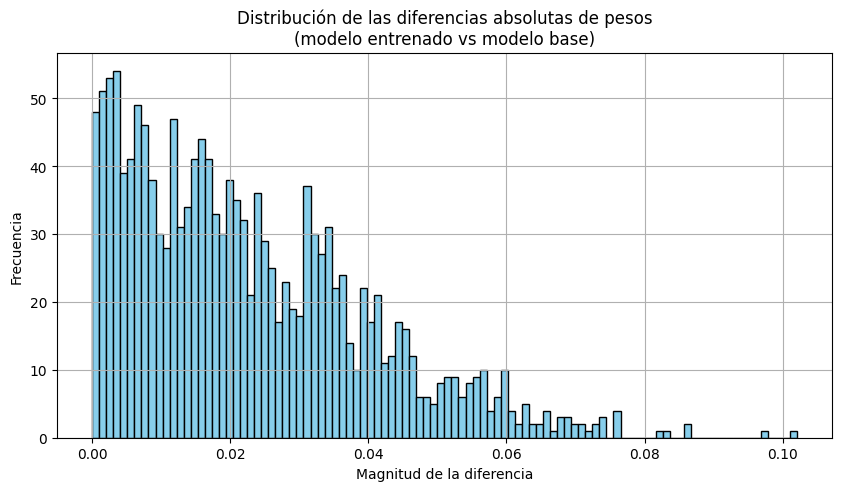

In [ ]:
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification

# Carga modelos
modelo_entrenado = AutoModelForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/BioBERT_Model_gsm_052025",
    trust_remote_code=True
)

modelo_base = AutoModelForSequenceClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.1",
    num_labels=2
)

# Obtiene pesos del clasificador
pesos_entrenado = modelo_entrenado.classifier.weight.detach().cpu().flatten()
pesos_base = modelo_base.classifier.weight.detach().cpu().flatten()

# Diferencias absolutas
diferencias = torch.abs(pesos_entrenado - pesos_base)

# Suma total
suma_diferencias = diferencias.sum().item()
print(f"Suma total de diferencias: {suma_diferencias:.6f}")

# Visualización
plt.figure(figsize=(10, 5))
plt.hist(diferencias.numpy(), bins=100, color="skyblue", edgecolor="black")
plt.title("Distribución de las diferencias absolutas de pesos\n(modelo entrenado vs modelo base)")
plt.xlabel("Magnitud de la diferencia")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


# Pre-procesamiento y Entenamiento - Modelo 2

Para entrenar el segundo modelo, se va a utilizar el conjunto que corresponderia al modelo SciBERT, a modo de que el modelo vea un conjunto totalmente nuevo

In [ ]:
# 7. Construir dataset con v2
print("\nConstruyendo dataset metodo de carga v2...")

# Ruta de la carpeta pdf_json
pdf_json_folder = '/content/CORD_19_DESCOMPRIMIDO/document_parses/pdf_json'
pmc_json_folder = '/content/CORD_19_DESCOMPRIMIDO/document_parses/pmc_json'

# Se cargará en base al dataframe que contiene los articulos no duplicados
"""Se cargara 100.000 samples. Sino da error el dataset se queda con esa cantidad para el entrenamiento"""
cord19_dataset_biobert_modelo_2 = build_dataset_v2(metadata_scibert, pmc_json_folder, pdf_json_folder, num_samples=120000)

# Ver el primer dataset
cord19_dataset_biobert_modelo_2[:1]


Construyendo dataset metodo de carga v2...
1000 muestras cargadas...
2000 muestras cargadas...
3000 muestras cargadas...
4000 muestras cargadas...
5000 muestras cargadas...
6000 muestras cargadas...
7000 muestras cargadas...
8000 muestras cargadas...
9000 muestras cargadas...
10000 muestras cargadas...
11000 muestras cargadas...
12000 muestras cargadas...
13000 muestras cargadas...
14000 muestras cargadas...
15000 muestras cargadas...
16000 muestras cargadas...
17000 muestras cargadas...
18000 muestras cargadas...
19000 muestras cargadas...
20000 muestras cargadas...
21000 muestras cargadas...
22000 muestras cargadas...
23000 muestras cargadas...
24000 muestras cargadas...
25000 muestras cargadas...
26000 muestras cargadas...
27000 muestras cargadas...
28000 muestras cargadas...
29000 muestras cargadas...
30000 muestras cargadas...
31000 muestras cargadas...
32000 muestras cargadas...
33000 muestras cargadas...
34000 muestras cargadas...
35000 muestras cargadas...
36000 muestras carga

{'title': [''],
 'abstract': [''],
 'body_text': ["In the space of a few weeks, the COVID-19 pandemic has changed the way neurology is practiced around the world. In order to control the spread of COVID-19, the World Health Organization (WHO) and Centers for Disease Control and Prevention (CDC) recommended isolation of sick persons, quarantine for those who may been exposed to the virus and social distancing. [1] Social distancing also referred to as physical distancing meant keeping space between people outside of their homes. A distance of at least 6 feet was recommended and people were asked not to gather in large groups, avoid crowded places and mass gatherings. [2] On March 24 th , 2020, Indian Prime Minister Narendra Modi announced the world's largest lockdown asking 1.3 billion Indians to stay home for 21 days to slow the spread of COVID-19. [3] The lockdown has now been extended till May 3 rd . [4] All international and national flights were suspended, as were the train and veh

In [ ]:
# 8. Limpiar el dataset. Se utiliza la versión 2
print("\n Limpiar el dataset...")
cord19_dataset_biobert_df_modelo_2 = preparar_data(cord19_dataset_biobert_modelo_2)


 Limpiar el dataset...


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [ ]:
# 9. Agregar la columna label al dataset a ser utilizado para el entrenamiento con BioBERT
cord19_dataset_biobert_df_modelo_2 = cord19_dataset_biobert_df_modelo_2.map(label_add)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [ ]:
# 10. Ver el primer registro del dataset
cord19_dataset_biobert_df_modelo_2[:1]

{'title': [''],
 'abstract': [''],
 'body_text': ["In the space of a few weeks, the COVID-19 pandemic has changed the way neurology is practiced around the world. In order to control the spread of COVID-19, the World Health Organization (WHO) and Centers for Disease Control and Prevention (CDC) recommended isolation of sick persons, quarantine for those who may been exposed to the virus and social distancing. [1] Social distancing also referred to as physical distancing meant keeping space between people outside of their homes. A distance of at least 6 feet was recommended and people were asked not to gather in large groups, avoid crowded places and mass gatherings. [2] On March 24 th , 2020, Indian Prime Minister Narendra Modi announced the world's largest lockdown asking 1.3 billion Indians to stay home for 21 days to slow the spread of COVID-19. [3] The lockdown has now been extended till May 3 rd . [4] All international and national flights were suspended, as were the train and veh

In [ ]:
# 11. Dividir el dataset en entrenamiento, validación y prueba
splits_biobert_modelo_2 = split_dataset(cord19_dataset_biobert_df_modelo_2, train_size=0.8, val_size=0.1, test_size=0.1, seed=42)

# Verificación de la división
print(splits_biobert_modelo_2)
print("Train samples:", len(splits_biobert_modelo_2['train']))
print("Validación samples:", len(splits_biobert_modelo_2['validation']))
print("Test samples:", len(splits_biobert_modelo_2['test']))


DatasetDict({
    train: Dataset({
        features: ['title', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'text', 'label'],
        num_rows: 96000
    })
    validation: Dataset({
        features: ['title', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'text', 'label'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['title', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'text', 'label'],
        num_rows: 12000
    })
})
Train samples: 96000
Validación samples: 12000
Test samples: 12000


In [ ]:
# 12. Tokenizar los datos usando múltiples columnas
tokenized_biobert_modelo_2 = tokenize_multicolumn_biobert(splits_biobert_modelo_2)

# Verificar una muestra
print(tokenized_biobert_modelo_2['train'][0])


Map:   0%|          | 0/96000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

{'title': 'Lessons learned about virtual cancer care and distress screening in the time of COVID-19', 'abstract': 'Purpose Cancer-related biopsychosocial distress is highly prevalent across the cancer care continuum. The implementation of screening patients for biopsychosocial distress has become a standard of practice in cancer care. With the presence of COVID-19, clinical care has shifted from in-person care to virtual care in many instances. One of the realities of COVID-19 is the significant decrease in screening patients for biopsychosocial symptom burden. Methods Given that screening for distress has become an accreditation standard in many cancer programs, in the province of Alberta, Canada, all patients are screened for distress with every visit to the cancer centre. Given the presence of COVID-19, much of cancer care has shifted to being delivered virtually (through mediums such as Zoom). In this paper, we present pre-and post-COVID data on the frequency of distress screening 

In [ ]:
# Antes de entrenar validar que tenga la columna label
print(tokenized_biobert_modelo_2['train'].features)

{'title': Value(dtype='string', id=None), 'abstract': Value(dtype='string', id=None), 'body_text': Value(dtype='string', id=None), 'bib_entries': Value(dtype='string', id=None), 'ref_entries': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


In [ ]:
# 13. Entrena BioBERT con clasificación binaria
# Extraer del diccionario cada conjunto divido para enviar de forma especifica el dataset a la función que hará el entrenamiento del modelo
tokenized_biobert_modelo_2_train = tokenized_biobert_modelo_2['train']
tokenized_biobert_modelo_2_val = tokenized_biobert_modelo_2['validation']

""" Solo se va a identificar si un artículo es sobre el COVID o no"""
trainer = train_biobert_classifier_modelo_2(tokenized_biobert_modelo_2_train, tokenized_biobert_modelo_2_val, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-107-237b6dd71f79>:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.240900,0.270419,0.874500,0.844080,0.851101,0.874500
1000,0.237800,0.238653,0.876583,0.856663,0.855516,0.876583
1500,0.224200,0.238677,0.879000,0.876923,0.875149,0.879000
2000,0.219500,0.221846,0.882750,0.880016,0.877844,0.882750
2500,0.240500,0.221506,0.882833,0.881757,0.880772,0.882833
3000,0.212200,0.224918,0.884833,0.876725,0.873185,0.884833
3500,0.230800,0.217729,0.887167,0.875089,0.872984,0.887167
4000,0.242600,0.226191,0.885833,0.864714,0.870169,0.885833
4500,0.210500,0.222548,0.888667,0.879792,0.876812,0.888667
5000,0.206800,0.224197,0.881750,0.883305,0.885062,0.881750


**Análisis General de los Resultados Modelo 1 - Entrenamiento 1**

El mejor modelo  estar alrededor de los steps 6000 y 6500, donde val_loss aún está bajo y las métricas están en su punto óptimo.

Después del step 7500 empieza a ser notorio el sobreajuste, aumenta la pérdida de validación y F1-score deja de mejorar.

Early stopping habría sido útil después de step 7000, ya que no hubo mejoras posteriores significativas.

**Análisis General de los Resultados Modelo 2 - Entrenamiento 2**

La Accuracy pasa de 0.8745 (step 500) a un máximo de 0.8887 (step 4500).

El F1-score también mejora consistentemente, alcanzando su pico en step 5000 (0.8833).

La Precisión y Recall se mantienen altas y bastante balanceadas a lo largo de todo el entrenamiento, lo que indica que el modelo no está sesgado hacia una clase en particular.

El Training Loss baja de 0.2409 a 0.2068, lo que indica que el modelo sigue aprendiendo.

El Validation Loss baja de 0.2704 a alrededor de 0.2215, pero luego fluctúa, lo cual sugiere que el modelo empieza a sobreajustarse levemente después de cierto punto (sube a 0.2261 en el step 4000).

Aun así, el desempeño en validación mejora, lo cual puede deberse a que el modelo generaliza bien incluso con ligera variabilidad en el loss.

El entrenamiento se detuvo en el step 5000 con 4 épocas y semilla para reproducibilidad seed=42.



In [ ]:
# 13. Entrena BioBERT con clasificación binaria
# Extraer del diccionario cada conjunto divido para enviar de forma especifica el dataset a la función que hará el entrenamiento del modelo
tokenized_biobert_modelo_2_train = tokenized_biobert_modelo_2['train']
tokenized_biobert_modelo_2_val = tokenized_biobert_modelo_2['validation']

""" Solo se va a identificar si un artículo es sobre el COVID o no"""
trainer = train_biobert_classifier_modelo_2(tokenized_biobert_modelo_2_train, tokenized_biobert_modelo_2_val, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-107-237b6dd71f79>:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.240900,0.270419,0.874500,0.844080,0.851101,0.874500
1000,0.237800,0.238653,0.876583,0.856663,0.855516,0.876583
1500,0.224200,0.238677,0.879000,0.876923,0.875149,0.879000
2000,0.219500,0.221846,0.882750,0.880016,0.877844,0.882750
2500,0.240500,0.221506,0.882833,0.881757,0.880772,0.882833
3000,0.212200,0.224918,0.884833,0.876725,0.873185,0.884833
3500,0.230800,0.217729,0.887167,0.875089,0.872984,0.887167
4000,0.242600,0.226191,0.885833,0.864714,0.870169,0.885833
4500,0.210500,0.222548,0.888667,0.879792,0.876812,0.888667
5000,0.206800,0.224197,0.881750,0.883305,0.885062,0.881750


# Pre-procesamiento y Entenamiento - Modelo 3

Para entrenar el segundo modelo, se va a utilizar el conjunto que corresponderia al modelo SciBERT, a modo de que el modelo vea un conjunto totalmente nuevo

In [ ]:
# 7. Construir dataset con v2
print("\nConstruyendo dataset metodo de carga v2...")

# Ruta de la carpeta pdf_json
pdf_json_folder = '/content/CORD_19_DESCOMPRIMIDO/document_parses/pdf_json'
pmc_json_folder = '/content/CORD_19_DESCOMPRIMIDO/document_parses/pmc_json'

# Se cargará en base al dataframe que contiene los articulos no duplicados
"""Se cargara 100.000 samples. Sino da error el dataset se queda con esa cantidad para el entrenamiento"""
cord19_dataset_biobert_modelo_3 = build_dataset_v2(metadata_biobert, pmc_json_folder, pdf_json_folder, num_samples=120000)

# Ver el primer dataset
cord19_dataset_biobert_modelo_3[:1]


Construyendo dataset metodo de carga v2...
1000 muestras cargadas...
2000 muestras cargadas...
3000 muestras cargadas...
4000 muestras cargadas...
5000 muestras cargadas...
6000 muestras cargadas...
7000 muestras cargadas...
8000 muestras cargadas...
9000 muestras cargadas...
10000 muestras cargadas...
11000 muestras cargadas...
12000 muestras cargadas...
13000 muestras cargadas...
14000 muestras cargadas...
15000 muestras cargadas...
16000 muestras cargadas...
17000 muestras cargadas...
18000 muestras cargadas...
19000 muestras cargadas...
20000 muestras cargadas...
21000 muestras cargadas...
22000 muestras cargadas...
23000 muestras cargadas...
24000 muestras cargadas...
25000 muestras cargadas...
26000 muestras cargadas...
27000 muestras cargadas...
28000 muestras cargadas...
29000 muestras cargadas...
30000 muestras cargadas...
31000 muestras cargadas...
32000 muestras cargadas...
33000 muestras cargadas...
34000 muestras cargadas...
35000 muestras cargadas...
36000 muestras carga

{'title': ['Valid and Reliable Assessment of Upper Respiratory Tract Specimen Collection Skills during the COVID-19 Pandemic'],
 'abstract': [''],
 'body_text': ['Testing for the novel severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) causing the coronavirus disease 2019 (COVID- 19) is an essential part of the pandemic control [1] . Millions of individuals are tested daily as a part of mass testing strategies to identify and isolate asymptomatic COVID-19 cases in society [2] . For initial SARS-CoV-2 infections, an upper respiratory tract specimen is recommended to be collected for molecular or antigen testing. The World Health Organization (WHO) recommends performing oropharyngeal (OPS) and nasopharyngeal swabbing (NPS) to ensure the collection of representative upper respiratory tract specimens for COVID-19 testing [3] . Proper specimen collection is considered the most important step in the diagnostic work-up of COVID-19 and suboptimal technique may lead to false-negative 

In [ ]:
# 8. Limpiar el dataset. Se utiliza la versión 2
print("\n Limpiar el dataset...")
cord19_dataset_biobert_df_modelo_3 = preparar_data(cord19_dataset_biobert_modelo_3)


 Limpiar el dataset...


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [ ]:
# 9. Agregar la columna label al dataset a ser utilizado para el entrenamiento con BioBERT
cord19_dataset_biobert_df_modelo_3 = cord19_dataset_biobert_df_modelo_3.map(label_add)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [ ]:
# 10. Ver el primer registro del dataset
cord19_dataset_biobert_df_modelo_3[:1]

{'title': ['Valid and Reliable Assessment of Upper Respiratory Tract Specimen Collection Skills during the COVID-19 Pandemic'],
 'abstract': [''],
 'body_text': ['Testing for the novel severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) causing the coronavirus disease 2019 (COVID- 19) is an essential part of the pandemic control [1] . Millions of individuals are tested daily as a part of mass testing strategies to identify and isolate asymptomatic COVID-19 cases in society [2] . For initial SARS-CoV-2 infections, an upper respiratory tract specimen is recommended to be collected for molecular or antigen testing. The World Health Organization (WHO) recommends performing oropharyngeal (OPS) and nasopharyngeal swabbing (NPS) to ensure the collection of representative upper respiratory tract specimens for COVID-19 testing [3] . Proper specimen collection is considered the most important step in the diagnostic work-up of COVID-19 and suboptimal technique may lead to false-negative 

In [ ]:
# 11. Dividir el dataset en entrenamiento, validación y prueba
splits_biobert_modelo_3 = split_dataset(cord19_dataset_biobert_df_modelo_3, train_size=0.8, val_size=0.1, test_size=0.1, seed=42)

# Verificación de la división
print(splits_biobert_modelo_3)
print("Train samples:", len(splits_biobert_modelo_3['train']))
print("Validación samples:", len(splits_biobert_modelo_3['validation']))
print("Test samples:", len(splits_biobert_modelo_3['test']))


DatasetDict({
    train: Dataset({
        features: ['title', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'text', 'label'],
        num_rows: 96000
    })
    validation: Dataset({
        features: ['title', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'text', 'label'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['title', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'text', 'label'],
        num_rows: 12000
    })
})
Train samples: 96000
Validación samples: 12000
Test samples: 12000


In [ ]:
# 12. Tokenizar los datos usando múltiples columnas
tokenized_biobert_modelo_3 = tokenize_multicolumn_biobert(splits_biobert_modelo_3)

# Verificar una muestra
print(tokenized_biobert_modelo_3['train'][0])


Map:   0%|          | 0/96000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

{'title': 'Learning Where to Look for COVID-19 Growth: Multivariate Analysis of COVID-19 Cases Over Time using Explainable Convolution-LSTM', 'abstract': 'Determinant factors which contribute to the prediction should take into account multivariate analysis for capturing coarse-to-fine contextual information. From the preliminary descriptive analysis, it shows that environmental factor such as UV (ultraviolet) is one of the essential factors that should be considered to observe the COVID-19 epidemic drivers, During summer, UV can inactivate viruses that live in the air and on the surface of the objects especially at noon in tropical or subtropical countries. However, it may not be significant in closed spaces like workspace and areas with the intensive human-to-human transmission, especially in densely populated areas. Different COVID-19 pandemic growth patterns in northern subtropical, southern subtropical and tropical countries occur over time. Moreover, there are education, governmen

In [ ]:
# Antes de entrenar validar que tenga la columna label
print(tokenized_biobert_modelo_3['train'].features)

{'title': Value(dtype='string', id=None), 'abstract': Value(dtype='string', id=None), 'body_text': Value(dtype='string', id=None), 'bib_entries': Value(dtype='string', id=None), 'ref_entries': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


In [ ]:
# 13. Entrena BioBERT con clasificación binaria

# Extraer del diccionario cada conjunto dividido
tokenized_biobert_modelo_3_train = tokenized_biobert_modelo_3['train']
tokenized_biobert_modelo_3_val = tokenized_biobert_modelo_3['validation']

# Lista de semillas para evaluar robustez
seeds = [42, 123, 2024, 2025, 999]

# Entrenar el modelo con cada semilla
for seed in seeds:
    print(f"\n Entrenando BioBERT con semilla {seed} ---")
    trainer = train_biobert_classifier_modelo_3(
        tok_train_dataset=tokenized_biobert_modelo_3_train,
        tok_eval_dataset=tokenized_biobert_modelo_3_val,
        num_labels=2,
        seed=seed
    )



 Entrenando BioBERT con semilla 42 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-120-8e12aeb39ac9>:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.230500,0.222705,0.881083,0.863958,0.862599,0.881083
1000,0.219600,0.218975,0.881417,0.881248,0.881081,0.881417
1500,0.214500,0.217095,0.887000,0.867657,0.871175,0.887000
2000,0.213400,0.213777,0.886917,0.869205,0.870922,0.886917
2500,0.220700,0.206611,0.891250,0.881958,0.879365,0.891250
3000,0.225000,0.209506,0.888000,0.884609,0.882157,0.888000
3500,0.186400,0.213440,0.892667,0.879768,0.879504,0.892667
4000,0.201100,0.215693,0.890500,0.876640,0.876419,0.890500



 Entrenando BioBERT con semilla 123 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-120-8e12aeb39ac9>:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.238400,0.228499,0.869917,0.873959,0.879129,0.869917
1000,0.219700,0.217360,0.883417,0.863869,0.865513,0.883417
1500,0.221700,0.213579,0.885250,0.881618,0.878992,0.885250
2000,0.205800,0.225734,0.877417,0.839517,0.863848,0.877417
2500,0.223100,0.208315,0.890083,0.884487,0.881437,0.890083
3000,0.212000,0.208024,0.889750,0.881514,0.878456,0.889750
3500,0.202300,0.215864,0.890417,0.879136,0.877213,0.890417
4000,0.188400,0.212748,0.889583,0.889598,0.889612,0.889583


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.238400,0.228499,0.869917,0.873959,0.879129,0.869917
1000,0.219700,0.217360,0.883417,0.863869,0.865513,0.883417
1500,0.221700,0.213579,0.885250,0.881618,0.878992,0.885250
2000,0.205800,0.225734,0.877417,0.839517,0.863848,0.877417
2500,0.223100,0.208315,0.890083,0.884487,0.881437,0.890083
3000,0.212000,0.208024,0.889750,0.881514,0.878456,0.889750
3500,0.202300,0.215864,0.890417,0.879136,0.877213,0.890417
4000,0.188400,0.212748,0.889583,0.889598,0.889612,0.889583
4500,0.191700,0.211709,0.895667,0.884860,0.883906,0.895667



 Entrenando BioBERT con semilla 2024 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-120-8e12aeb39ac9>:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.239100,0.227411,0.875667,0.877509,0.879598,0.875667
1000,0.217600,0.226772,0.872000,0.877022,0.883933,0.872000
1500,0.219600,0.215986,0.881500,0.854056,0.864013,0.881500
2000,0.220300,0.214027,0.882250,0.886811,0.893293,0.882250
2500,0.211300,0.216209,0.884333,0.888232,0.893566,0.884333
3000,0.197200,0.210799,0.890750,0.878992,0.877409,0.890750
3500,0.202400,0.217182,0.883250,0.888144,0.895333,0.883250
4000,0.205000,0.209066,0.893333,0.877307,0.880422,0.893333
4500,0.185500,0.205873,0.894917,0.882641,0.882582,0.894917
5000,0.207800,0.206539,0.895000,0.882664,0.882681,0.895000



 Entrenando BioBERT con semilla 2025 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-120-8e12aeb39ac9>:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.236000,0.233660,0.862083,0.871359,0.886840,0.862083
1000,0.220000,0.230515,0.876917,0.840548,0.859982,0.876917
1500,0.212900,0.212019,0.888167,0.867660,0.873431,0.888167
2000,0.231200,0.211407,0.888083,0.869438,0.872794,0.888083
2500,0.217700,0.209040,0.889333,0.872762,0.874519,0.889333
3000,0.214300,0.210426,0.893167,0.879146,0.880031,0.893167
3500,0.207300,0.209011,0.890917,0.888539,0.886668,0.890917
4000,0.196600,0.210093,0.892417,0.883518,0.880984,0.892417
4500,0.199300,0.210637,0.890000,0.889306,0.888657,0.890000
5000,0.194700,0.203635,0.898167,0.891439,0.889073,0.898167



 Entrenando BioBERT con semilla 999 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-120-8e12aeb39ac9>:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.237400,0.227891,0.874500,0.872109,0.870073,0.874500
1000,0.219800,0.220098,0.881167,0.878800,0.876836,0.881167
1500,0.224600,0.213943,0.883750,0.866836,0.866410,0.883750
2000,0.216600,0.212766,0.887750,0.877080,0.874339,0.887750
2500,0.211800,0.210321,0.890500,0.884943,0.881924,0.890500
3000,0.212900,0.208822,0.891833,0.878932,0.878408,0.891833
3500,0.195200,0.215980,0.892083,0.877996,0.878534,0.892083
4000,0.192100,0.211594,0.891333,0.890325,0.889413,0.891333
4500,0.204600,0.209760,0.895667,0.886608,0.884670,0.895667


**Análisis General de los Resultados**

Los resultados muestran que el modelo es bastante estable frente a diferentes semillas, con variaciones muy pequeñas en las métricas clave.

La semilla 2025 es el que tiene los mejores resultados:

Accuracy:   0.898167  
F1:         0.891439  
Precision:  0.889073  
Recall:     0.898167  

Rendimiento muy consistente entre los entrenamientos con diferentes semillas, lo que indica que el modelo y el proceso de fine-tuning son estables.



Copiar el modelo guardado en content a Google Drive

In [ ]:
# 14. Guardar modelo BioBert con Fine-Tunning en una carpeta de Google Drive
import shutil

# Ruta local donde está guardado el modelo
ruta_local = "/content/saved_model_3"

# Ruta destino en tu Google Drive
ruta_drive = "/content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/BioBERT_Model3_gsm_052025"

# Copiar la carpeta del modelo y sobreescribir si ya existe
shutil.copytree(ruta_local, ruta_drive, dirs_exist_ok=True)


'/content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/BioBERT_Model3_gsm_052025'

Guardar las métricas en Google Drive

In [ ]:
import shutil
import os

# Ruta al archivo JSON local ya existente
ruta_json_local = "/content/results_biobert_model_3/eval_metrics_seed_2025.json"

# Ruta destino en Google Drive
ruta_destino_drive = "/content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/BioBERT_Model3_gsm_052025/eval_metrics_seed_2025.json"

# Copiar y reemplazar el archivo JSON en Drive
shutil.copy2(ruta_json_local, ruta_destino_drive)

print("Archivo JSON de métricas copiado exitosamente a Drive.")


Archivo JSON de métricas copiado exitosamente a Drive.


# Evaluación de los modelos

**Evaluación del Modelo 1 - 02/05/2025**

In [ ]:
# 16. Cargar el modelo guardado y evaluarlo con el conjunto de datos test
ruta_modelo = "/content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/BioBERT_Model_gsm_052025"  # Ajustar al path real donde se guardo el modelo entrenado
evaluar_modelo_guardado(ruta_modelo, tokenized_biobert['test'])


<ipython-input-59-3a80550f8478>:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



 Métricas del modelo evaluado:
accuracy: 0.3321
f1: 0.3940
precision: 0.7247
recall: 0.3321


{'accuracy': 0.3321,
 'f1': 0.39400122220133826,
 'precision': 0.724686183353314,
 'recall': 0.3321}

*Análisis de los resultados:*

---



Hay una gran diferencia entre las métricas de validación y test, especialmente en accuracy y recall. Eso indica  overfitting: el modelo se ajustó muy bien a los datos de entrenamiento/validación pero no generaliza bien al conjunto de test o el modelo entrenado no se guardo.

**Evaluación del Modelo 2 - 03/05/2025**

El modelo 2 no fue evaluado, ya que las métricas arrojadas por el modelo no fueron buenas, en especial en el validation loss y solo se ejecuto una época.

**Evaluación del Modelo 3 - 04/05/2025**

In [ ]:
# 15. Cargar el modelo guardado y evaluarlo con el conjunto de datos test
ruta_modelo = "/content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/BioBERT_Model3_gsm_052025"  # Ajustar al path real donde se guardo el modelo entrenado
evaluar_modelo_guardado(ruta_modelo, tokenized_biobert_modelo_3['test'])


<ipython-input-59-3a80550f8478>:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



 Métricas del modelo evaluado:
accuracy: 0.8891
f1: 0.8750
precision: 0.8750
recall: 0.8891


{'accuracy': 0.8890833333333333,
 'f1': 0.8750170258081613,
 'precision': 0.8750255279444782,
 'recall': 0.8890833333333333}

*Análisis de los resultados:*

---



El modelo está bien balanceado en precisión y recall.

La accuracy es alta, lo que sugiere buen rendimiento general.

El F1-score alto indica que no hay un trade-off excesivo entre precisión y recall.

El modelo parece estable y no está sobreajustado ya que se obtuvieron del conjunto de test.

El modelo 3 es el modelo final y será utilizado para clasificar los textos para el RAG.

**Evaluación del Modelo 3 - 05/05/2025**

In [ ]:
# 1. Construir dataset con v2
print("\nConstruyendo dataset metodo de carga v2...")

# Ruta de la carpeta pdf_json
pdf_json_folder = '/content/CORD_19_DESCOMPRIMIDO/document_parses/pdf_json'
pmc_json_folder = '/content/CORD_19_DESCOMPRIMIDO/document_parses/pmc_json'

# Se cargará en base al dataframe que contiene los articulos no duplicados
"""Se cargara 80.000 samples para volver a evaluar el rendimiento del modelo guardado y se utilizará el dataset SciBERT"""
cord19_dataset_biobert_modelo_3_eval = build_dataset_v2(metadata_scibert, pmc_json_folder, pdf_json_folder, num_samples=80000)

# Ver el primer dataset
cord19_dataset_biobert_modelo_3_eval [:1]


Construyendo dataset metodo de carga v2...
1000 muestras cargadas...
2000 muestras cargadas...
3000 muestras cargadas...
4000 muestras cargadas...
5000 muestras cargadas...
6000 muestras cargadas...
7000 muestras cargadas...
8000 muestras cargadas...
9000 muestras cargadas...
10000 muestras cargadas...
11000 muestras cargadas...
12000 muestras cargadas...
13000 muestras cargadas...
14000 muestras cargadas...
15000 muestras cargadas...
16000 muestras cargadas...
17000 muestras cargadas...
18000 muestras cargadas...
19000 muestras cargadas...
20000 muestras cargadas...
21000 muestras cargadas...
22000 muestras cargadas...
23000 muestras cargadas...
24000 muestras cargadas...
25000 muestras cargadas...
26000 muestras cargadas...
27000 muestras cargadas...
28000 muestras cargadas...
29000 muestras cargadas...
30000 muestras cargadas...
31000 muestras cargadas...
32000 muestras cargadas...
33000 muestras cargadas...
34000 muestras cargadas...
35000 muestras cargadas...
36000 muestras carga

{'title': [''],
 'abstract': [''],
 'body_text': ["In the space of a few weeks, the COVID-19 pandemic has changed the way neurology is practiced around the world. In order to control the spread of COVID-19, the World Health Organization (WHO) and Centers for Disease Control and Prevention (CDC) recommended isolation of sick persons, quarantine for those who may been exposed to the virus and social distancing. [1] Social distancing also referred to as physical distancing meant keeping space between people outside of their homes. A distance of at least 6 feet was recommended and people were asked not to gather in large groups, avoid crowded places and mass gatherings. [2] On March 24 th , 2020, Indian Prime Minister Narendra Modi announced the world's largest lockdown asking 1.3 billion Indians to stay home for 21 days to slow the spread of COVID-19. [3] The lockdown has now been extended till May 3 rd . [4] All international and national flights were suspended, as were the train and veh

In [ ]:
# 2. Limpiar el dataset. Se utiliza la versión 2
print("\n Limpiar el dataset...")
cord19_dataset_biobert_df_modelo_3_eval = preparar_data(cord19_dataset_biobert_modelo_3_eval)


 Limpiar el dataset...


Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

In [ ]:
# 3. Agregar la columna label al dataset a ser utilizado para el entrenamiento con BioBERT
cord19_dataset_biobert_df_modelo_3_eval = cord19_dataset_biobert_df_modelo_3_eval.map(label_add)

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

In [ ]:
# 3. Dividir el dataset en entrenamiento, validación y prueba
splits_biobert_modelo_3_eval = split_dataset(cord19_dataset_biobert_df_modelo_3_eval, train_size=0.5, val_size=0.25, test_size=0.25, seed=42)

# Verificación de la división
print(splits_biobert_modelo_3_eval)
print("Train samples:", len(splits_biobert_modelo_3_eval['train']))
print("Validación samples:", len(splits_biobert_modelo_3_eval['validation']))
print("Test samples:", len(splits_biobert_modelo_3_eval['test']))


DatasetDict({
    train: Dataset({
        features: ['title', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'text', 'label'],
        num_rows: 40000
    })
    validation: Dataset({
        features: ['title', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'text', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['title', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'text', 'label'],
        num_rows: 20000
    })
})
Train samples: 40000
Validación samples: 20000
Test samples: 20000


In [ ]:
# 12. Tokenizar los datos solo para el conjunto de test
tokenized_biobert_modelo_3_eval = tokenize_multicolumn_biobert(splits_biobert_modelo_3_eval['test'])

# Verificar una muestra
print(tokenized_biobert_modelo_3_eval['title'][0])


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

INQUIRY: The Journal of Health Care Organization, Provision, and Financing


In [ ]:
# 4. Cargar el modelo guardado y evaluarlo con el conjunto de datos test
ruta_modelo = "/content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/BioBERT_Model3_gsm_052025"  # Ajustar al path real donde se guardo el modelo entrenado
evaluar_modelo_guardado(ruta_modelo, tokenized_biobert_modelo_3_eval)


<ipython-input-18-3a80550f8478>:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



 Métricas del modelo evaluado:
accuracy: 0.8902
f1: 0.8769
precision: 0.8771
recall: 0.8902


{'accuracy': 0.8902,
 'f1': 0.8769186474949449,
 'precision': 0.8770573404527892,
 'recall': 0.8902}

*Análisis de los resultados:*

---

Los resultados de está segunda evaluación indican que el modelo 3 fine-tuneado está funcionando bien, ya que utilizamos el dataset que correspondía al metadata para sciBERT.

Interpretación de las métricas:  
*Accuracy:*	0.8902 - El 89.02% de las predicciones del modelo fueron correctas.  
*Precision:*	0.8771	- Cuando el modelo predice una clase positiva  acierta el 87.71% de las veces.  
*Recall:*	0.8902	- El modelo identifica correctamente el 89.02% de los ejemplos positivos.  
*F1 Score:*	0.8769 - Promedio armónico entre precisión y recall, refleja un buen equilibrio.  

En conclusión el modelo ha aprendido patrones útiles en el entrenamiento realizado.

Tiene un buen balance entre precisión y recall, lo que significa que no solo acierta con frecuencia, sino que tampoco se le escapan muchos casos positivos.

El valor de f1 muy cercano a accuracy y recall indica que no hay un gran desbalance de clases o que el modelo lo está manejando bien.

# RAG para la clasificación de textos como "COVID" o "No COVID", utilizando el modelo BioBERT entrenado para la clasificación y FAISS para la recuperación de documentos.

In [ ]:
!pip install langchain-community
!pip install langchain openai faiss-cpu unstructured
!pip install pypdf python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.4/189.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 9.6 MB/s eta 0:00:00
  Create

In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.4 MB/s eta 0:00:00


In [ ]:
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import os
from google.colab import userdata # Para obtener la clave OpenIA

**1. Carga de cuenta en OpenAILinks**

Se utilizó secretos de Colab para añadir la clave OpenIA y luego se accedera a ella mediante código

In [ ]:
openai_api_key = userdata.get('OPENAI_API_KEY')

if openai_api_key:
    os.environ["OPENAI_API_KEY"] = openai_api_key
    print("La clave de OpenAI fue cargada en Colab.")
else:
    print("Advertencia: La clave de OpenAI no se encontró cargada en Colab.")

La clave de OpenAI fue cargada en Colab.


**2. Extracción de Texto de los archivos XML almacenados en Google Drive**

In [ ]:
import os
import json
from tqdm import tqdm  # Barra de progreso

def extract_text_from_xml_folder(folder_path):
    """
    Extrae texto del campo 'body_text' de archivos .xml.json en la carpeta donde se encuentra almacenado.

    Parámetros:
      - folder_path (str): Ruta a la carpeta que contiene archivos .xml.json

    Return:
      - list: Lista de textos extraídos desde los archivos JSON válidos
    """
    docs = []  # Lista para almacenar los textos extraídos

    # Filtrar solo archivos .xml.json
    files = [f for f in os.listdir(folder_path) if f.endswith(".xml.json")]

    # Usar tqdm para mostrar progreso
    for filename in tqdm(files, desc="Cargando documentos"):
        filepath = os.path.join(folder_path, filename)

        try:
            with open(filepath, "r", encoding="utf-8") as f:
                data = json.load(f)
                body = data.get("body_text", [])

                if isinstance(body, list):
                    text = " ".join([item.get("text", "") for item in body])
                    docs.append(text)

        except Exception as e:
            print(f" Error de lectura {filename}: {e}")

    print(f"\n Archivos cargados correctamente: {len(docs)}")
    return docs

Embedding y creación de FAISS Index

In [ ]:
from typing import List  # Import List from typing
from langchain.text_splitter import RecursiveCharacterTextSplitter # Import RecursiveCharacterTextSplitter
import time

def create_faiss_index_from_docs(
    docs: List[str], embedding_model: OpenAIEmbeddings, chunk_size: int = 3000, batch_size: int = 100, save_path: str = None) -> FAISS:
    """
    Crea un índice FAISS a partir de una lista de documentos.

    Parámetros:
    - docs: Lista de documentos de texto.
    - embedding_model: Modelo de embeddings (OpenAIEmbeddings).
    - chunk_size: Número de documentos a procesar en cada lote.
    - batch_size: Tamaño del lote de documentos.
    - save_path: Ruta para guardar el índice FAISS (opcional).

    Return:
    - vector_store: índice FAISS creado.
    """
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=0)
    all_texts = []
    for doc in tqdm(docs, desc="Dividiendo documentos: "):
        # Extrae text content antes de la creación de los documentos
        texts = text_splitter.create_documents([doc])
        all_texts.extend([t.page_content for t in texts])

    # Embedding de documentos en lotes con limitación de velocidad
    embeddings = []
    # Tamaño de lote reducido a 10 y añadido un temporizador de espera dinámico.
    sleep_time = 1  # Tiempo de espera
    batch_size = 10
    for i in tqdm(range(0, len(all_texts), batch_size), desc="Embedding documentos: "):
        batch = all_texts[i : i + batch_size]
        # **Change: Embed the batch directly since it contains the 'page_content' strings.**
        embeddings.extend(embedding_model.embed_documents(batch))
        time.sleep(sleep_time)  # Pausa para evitar la limitación de velocidad.
        # Ajustar el tiempo de espera dinámicamente en función del tamaño del lote y los límites de tasa observados
        sleep_time = max(2, sleep_time + (batch_size / 10))

    # Crear FAISS index
    vector_store = FAISS.from_embeddings(
        [(all_texts[i], embeddings[i]) for i in range(len(all_texts))],
        embedding_model,
    )

    if save_path:
        vector_store.save_local(save_path)
        print(f"Guardar FAISS index: {save_path}")

    return vector_store

# Ruta a la carpeta de XML en Drive
# Se carga un número limitado de archivos para trabajar
xml_folder_path = "/content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/CORD_19"

# Extraer textos de los XML
docs = extract_text_from_xml_folder(xml_folder_path)

# Crear modelo de embeddings
embedding_model = OpenAIEmbeddings()

# Crear índice FAISS usando la función create_faiss_index_from_docs
vector_store = create_faiss_index_from_docs(docs, embedding_model, save_path="/content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/CORD_19")

print("Índice FAISS guardado en Google Drive.")

Cargando documentos: 100%|██████████| 25/25 [00:00<00:00, 142.61it/s]



 Archivos cargados correctamente: 25


Embedding documentos: 100%|██████████| 28/28 [07:02<00:00, 15.08s/it]

Guardar FAISS index: /content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/CORD_19
Índice FAISS guardado en Google Drive.


Número de tokens generados

In [ ]:
import tiktoken

# Selecciona el tokenizador correcto según el modelo
# "gpt-3.5-turbo" o "gpt-4"
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

# Texto de entrada
text = "Este es un ejemplo de texto para contar los tokens generados."

# Obtener los tokens
tokens = encoding.encode(text)

# Mostrar cantidad de tokens
print("Número de tokens:", len(tokens))


Número de tokens: 13


**4. Cargar el modelo 3 BioBERT fine-tuneado**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Rutas al modelo y tokenizador fine-tuneado
model_path = "/content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/BioBERT_Model3_gsm_052025"
tokenizer_path = "/content/drive/MyDrive/Proyecto_Final_Topicos_Especiales_II/BioBERT_Model3_gsm_052025"

# Cargar modelo y tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


**5. Función para consultar FAISS + clasificar con BioBERT**

In [ ]:
def classify_query_with_biobert(query, k=3, max_length=512):
    """
    Clasifica una consulta ingresada por el usuario utilizando el modelo BioBERT y un índice FAISS.

    Parámetros:
    - query (str): consulta del usuario
    - k (int): Número de documentos más similares a recuperar del índice FAISS.
    - max_length (int): Longitud máxima de los tokens para el modelo.

    Return:
    - label (str): La clasificación del artículo como "COVID" o "No COVID".
    - concatenated_text (str): Los documentos recuperados concatenados.
    """

    # Recuperar los textos más similares desde el índice FAISS
    # 'vector_store' debe estar previamente cargado y contener el índice FAISS
    similar_docs = vector_store.similarity_search(query, k=k)  # Recupera k documentos más similares
    concatenated_text = "\n".join([doc.page_content for doc in similar_docs])  # Concatenar los textos

    # Tokenizar los textos recuperados y preparar los inputs para BioBERT
    # 'max_length' se pasa al tokenizador para asegurar que los textos no excedan el límite de tokens
    inputs = tokenizer(concatenated_text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)

    # Clasificación utilizando el modelo BioBERT entrenado
    with torch.no_grad():  # No se necesitan gradientes para la inferencia
        outputs = model(**inputs)  # Obtener las salidas del modelo
        logits = outputs.logits  # Extraer los logits (resultados no procesados)
        prediction = torch.argmax(logits, dim=-1)  # Predecir la clase con el valor más alto de logits

    # Paso 5: Mapear el valor de la predicción a las etiquetas correspondientes
    label_map = {0: "No COVID", 1: "COVID"}  # Diccionario de mapeo de las clases
    label = label_map[prediction.item()]  # Obtener la etiqueta final

    # Paso 6: Retornar el resultado
    return label, concatenated_text




**6. Pruebas del RAG**

Pregunta directa en Español

In [ ]:
# Probar la función con una consulta
query = "Estudios recientes sobre la transmisión del SARS-CoV-2 en ambientes hospitalarios"
label, docs = classify_query_with_biobert(query=query, k=3, max_length=512)  # Pass query explicitly

# Mostrar resultados
print("Clasificación:", label)
print("\nDocumentos relacionados:")
print(docs)

Clasificación: COVID

Documentos relacionados:
SARS-CoV-2 infection, which may have introduced a bias in the reporting of results, leading to misclassification. Other study limitations include insufficient data to model the antibody response according to different vaccines. Immunity due to either previous SARS-CoV-2 infection or vaccination can contribute to herd immunity and control the COVID-19 pandemic. Our study, together with others, underscores the fact that previous SARS-CoV-2 infection should be considered when planning booster doses and the design of COVID-19 vaccination strategies. Further studies should be conducted in the following months and after the booster dose to reassess seroprevalence and identify factors associated with infection among PHCWs.
Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) is a novel coronavirus that emerged in 2019 and is the causative agent of the highly transmissible and highly pathogenic coronavirus disease 2019 (COVID-19) [1]. The 

Pregunta directa en Inglés

In [ ]:
# Paso 5: Probar la función con una consulta
query = "Recent studies on the transmission of SARS-CoV-2 in hospital settings"
label, docs = classify_query_with_biobert(query=query, k=3, max_length=512)  # Pass query explicitly

# Mostrar resultados
print("Clasificación:", label)
print("\nDocumentos relacionados:")
print(docs)

Clasificación: COVID

Documentos relacionados:
SARS-CoV-2 infection, which may have introduced a bias in the reporting of results, leading to misclassification. Other study limitations include insufficient data to model the antibody response according to different vaccines. Immunity due to either previous SARS-CoV-2 infection or vaccination can contribute to herd immunity and control the COVID-19 pandemic. Our study, together with others, underscores the fact that previous SARS-CoV-2 infection should be considered when planning booster doses and the design of COVID-19 vaccination strategies. Further studies should be conducted in the following months and after the booster dose to reassess seroprevalence and identify factors associated with infection among PHCWs.
Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) is a novel coronavirus that emerged in 2019 and is the causative agent of the highly transmissible and highly pathogenic coronavirus disease 2019 (COVID-19) [1]. The 

Usuario ingresa consulta

In [ ]:
while True:
    # Solicitar al usuario que ingrese una consulta
    query = input("Ingrese su consulta / Enter your query (o escriba 'salir' para terminar / or type 'exit' to quit): ")

    # Verificar si el usuario desea salir
    if query.lower() in ['salir', 'exit']:
        print("Programa finalizado / Program exited.")
        break

    # Clasificar la consulta usando BioBERT
    label, docs = classify_query_with_biobert(query=query, k=3, max_length=512)

    # Mostrar los resultados
    print("Clasificación / Classification:", label)
    print("\nDocumentos relacionados / Related documents:")
    print(docs)



Ingrese su consulta / Enter your query (o escriba 'salir' para terminar / or type 'exit' to quit): ¿Qué estudios se han realizado sobre la transmisión aérea del COVID-19?
Clasificación / Classification: COVID

Documentos relacionados / Related documents:
SARS-CoV-2 infection, which may have introduced a bias in the reporting of results, leading to misclassification. Other study limitations include insufficient data to model the antibody response according to different vaccines. Immunity due to either previous SARS-CoV-2 infection or vaccination can contribute to herd immunity and control the COVID-19 pandemic. Our study, together with others, underscores the fact that previous SARS-CoV-2 infection should be considered when planning booster doses and the design of COVID-19 vaccination strategies. Further studies should be conducted in the following months and after the booster dose to reassess seroprevalence and identify factors associated with infection among PHCWs.
Since the identific

Para sacar la lista de requerimientos

In [ ]:
!pip show pandas numpy scikit-learn transformers torch

Name: pandas
Version: 2.2.2
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License

Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
All rights reserved.

Copyright (c) 2011-2023, Open source contributors.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be u